# 0. Setup and Data Loading

In [1]:
# if you have errors run the command pip install -r requirements.txt
import os
import json
import nltk 
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import math
import numpy as np
import collections
from numpy import linalg as la
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\didac\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\didac\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\didac\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\didac\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\didac\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [3]:
docs_path = os.path.join('..', '..', 'data', 'fashion_products_dataset.json')

with open(docs_path, 'r') as f:
    products = json.load(f)

print("Total number of products in the corpus: {}".format(len(products)))

Total number of products in the corpus: 28080


In order to justify why we remove 'no' and 'not' as stopwords, we printed the description fields for each json object and we can see that some description adds: 'do not dryclean' or 'do not wash' which is important for the product description.

In [4]:
for prod in products:
    desc = prod.get('description', '').lower()
    if "not" in desc:
        print("→", desc)
        print("-" * 80)

→ we nextedgeretails are a professional tie manufacturer. we focus on ties for many years and in our store, we have many other styles (neckties,bow ties,tie sets,etc.) for sell which are bound to meet your needs, you can click our brand name nu-lite to choose. our products are famous for their comfort, durability and design because of the reliable quality, our products have been highly favored of the majority of customers. besides they also would be perfect gifts or excellent additions to your wardrobe as well as for all fashion forward women, this tie is going to be a perfect pick. make your monday meetings more fun with this tie and show the world your style. wearing an elegant woman tie is an effective way to make you look charming and energetic. be stylish and make a new style statement with nu-lite that includes a great range of formal/casual slim neckties with pocket square for women. these ties looks good with most shirts, winning you compliments wherever you go and it. comes wi

In order to add some other stopwords particular to our search engine we printed the top 50 most appeared words in the raw description field in order to analyze if some should be removed or not. 

In [5]:
from collections import Counter
import re

all_desc = " ".join([prod.get("description", "").lower() for prod in products])
all_desc = re.sub(rf"[{re.escape(string.punctuation)}0-9]", " ", all_desc)
tokens = word_tokenize(all_desc)
counter = Counter(tokens)

k = 50
print(f"Top {k} most frequent words in raw descriptions:")
for word, freq in counter.most_common(k):
    print(f"{word:<15} {freq}")


Top 50 most frequent words in raw descriptions:
and             31026
the             23352
a               19653
for             19380
with            15500
to              15155
t               14755
of              14652
you             13964
this            13217
shirt           12520
is              12504
in              11959
it              10742
cotton          10139
your            9318
wear            8748
casual          5954
s               5866
from            5812
shirts          5800
made            5642
are             5596
fit             5391
or              5317
look            5303
fabric          4968
that            4870
comfort         4866
on              4596
be              4131
all             4099
quality         4075
women           3907
comfortable     3865
can             3841
as              3427
men             3193
these           3175
which           3143
feel            3003
neck            2991
wash            2971
day             2959
perfect      

In order to decide if we want to use a stemmer only or we should also add a lemmatizer, we tried with relevant words found in our dataset and tried 4 different combinations in order to evaluate which one should be our approach. 

In [6]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

words = ["dresses", "women", "stylish", "great", "printed", "quality"]

print(f"{'Word':<12}{'Stemmed':<12}{'Lemmatized':<12}{'Lem+Stem':<12}{'Stem+Lem':<12}")
print("-" * 60)
for w in words:
    stemmed = stemmer.stem(w)
    lemmatized = lemmatizer.lemmatize(w)
    lem_then_stem = stemmer.stem(lemmatizer.lemmatize(w))
    stem_then_lem= lemmatizer.lemmatize(stemmer.stem(w))
    print(f"{w:<12}{stemmed:<12}{lemmatized:<12}{lem_then_stem:<12}{stem_then_lem:<12}")


Word        Stemmed     Lemmatized  Lem+Stem    Stem+Lem    
------------------------------------------------------------
dresses     dress       dress       dress       dress       
women       women       woman       woman       woman       
stylish     stylish     stylish     stylish     stylish     
great       great       great       great       great       
printed     print       printed     print       print       
quality     qualiti     quality     qualiti     qualiti     


In [7]:
#Display the first 5 products
display(products[:5])

#Display the keys of the first product to see available information
if products:
    print("\nKeys available for each product:")
    print(products[0].keys())

[{'_id': 'fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a',
  'actual_price': '2,999',
  'average_rating': '3.9',
  'brand': 'York',
  'category': 'Clothing and Accessories',
  'crawled_at': 1612987911000,
  'description': 'Yorker trackpants made from 100% rich combed cotton giving it a rich look.Designed for Comfort,Skin friendly fabric,itch-free waistband & great for all year round use Proudly made in India',
  'discount': '69% off',
  'images': ['https://rukminim1.flixcart.com/image/128/128/jr3t5e80/track-pant/z/y/n/m-1005combo2-yorker-original-imafczg3xfh5qqd4.jpeg?q=70',
   'https://rukminim1.flixcart.com/image/128/128/jr58l8w0/track-pant/w/d/a/l-1005combo8-yorker-original-imafczg3pgtxgraq.jpeg?q=70'],
  'out_of_stock': False,
  'pid': 'TKPFCZ9EA7H5FYZH',
  'product_details': [{'Style Code': '1005COMBO2'},
   {'Closure': 'Elastic'},
   {'Pockets': 'Side Pockets'},
   {'Fabric': 'Cotton Blend'},
   {'Pattern': 'Solid'},
   {'Color': 'Multicolor'}],
  'seller': 'Shyam Enterprises',
  'selling_


Keys available for each product:
dict_keys(['_id', 'actual_price', 'average_rating', 'brand', 'category', 'crawled_at', 'description', 'discount', 'images', 'out_of_stock', 'pid', 'product_details', 'seller', 'selling_price', 'sub_category', 'title', 'url'])


# 1. Part 1: Data Preparation

## 1.1. Preprocessing Functions

In [8]:
def setup_preprocessing_tools():
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    stop_words.update(['made', 'wear', 'comfort', 'quality', 
                       'look', 'perfect', 'style', 'great', 'cool'])
    stop_words.discard('no')
    stop_words.discard('not')
    return stemmer, lemmatizer, stop_words

In [9]:
def preprocess_text(text, lemmatizer, stemmer, stop_words):
    """
    Preprocess natural text:
    - lowercase
    - remove punctuation/numbers
    - tokenize
    - remove stopwords and non-alphabetic tokens
    - stem + lemmatize
    """
    if not isinstance(text, str):
        return []
    
    text = text.replace('-', ' ')

    # lowercase
    text = text.lower()

    # remove punctuation and digits
    text = re.sub(f"[{re.escape(string.punctuation)}0-9]", " ", text)

    # tokenize
    tokens = word_tokenize(text)

    # filter tokens (stopwords, non-alpha, short tokens)
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]

    # stem + lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens = [stemmer.stem(w) for w in tokens]

    # normalize color terms 
    color_map = {'navy': 'blue', 'grey': 'gray', 'fucsia': 'pink', 'burgundy': 'red', 'violet': 'purple', 'beige': 'brown', 'magenta': 'pink', 'indigo': 'blue', 
                 'charcoal': 'gray', 'crimson': 'red', 'teal': 'green', 'lavender': 'purple', 'mustard': 'yellow', 'turquoise': 'blue', 'peach': 'orange'}

    tokens = [color_map.get(w, w) for w in tokens]

    return tokens


In [10]:
#Apply some preprocessing to categorical fields such as "brand". Here we only use conversion to lowercase and join everything into a single token, since it's already clean for the most part
def clean_categorical(value):
    """Few processing for categorical fields"""
    if not isinstance(value, str):
        return None

    #Just convert to lowercase and join everything into a single token separating words by "_"
    return value.lower().strip().replace(' ', '_')

In [11]:
def clean_numeric(value, value_type='float'):
  """Convert strings to numeric values"""
  if not isinstance(value, str):
      return None

  #Eliminate non-numerical characters (except dots)
  cleaned_value = re.sub(r'[^0-9.]', '', value)
  if not cleaned_value:
      return None

  try:
      if value_type == 'int':
          return int(float(cleaned_value))
      else:
          return float(cleaned_value)
  except (ValueError, TypeError):
      return None

## 1.2. Build the  Clean Corpus

In [12]:
stemmer, lemmatizer, stop_words = setup_preprocessing_tools()

processed_corpus = []
for prod in products:
    processed_prod={
        'pid': prod.get('pid'),
        'url': prod.get('url'),
    }

    # text fields

    title_text = prod.get('title', '') or ''
    description_text = prod.get('description', '') or ''
    full_text = title_text + " " + description_text

    processed_prod['processed_text'] = preprocess_text(full_text, lemmatizer, stemmer, stop_words)

    #store raw title/description to include in final output
    processed_prod['title'] = prod.get('title')
    processed_prod['description'] = prod.get('description')

    #Processing of categorical fields
    processed_prod['brand_facet'] = clean_categorical(prod.get('brand'))
    processed_prod['category_facet'] = clean_categorical(prod.get('category'))
    processed_prod['subcategory_facet'] = clean_categorical(prod.get('sub_category'))
    processed_prod['seller_facet'] = clean_categorical(prod.get('seller'))

    #Processing of numerical fields (passed to float)
    processed_prod['discount'] = clean_numeric(prod.get('discount'), 'float')
    processed_prod['selling_price'] = clean_numeric(prod.get('selling_price'), 'float')
    processed_prod['actual_price'] = clean_numeric(prod.get('actual_price'), 'float')
    processed_prod['average_rating'] = clean_numeric(prod.get('average_rating'), 'float')
    
    #Process product_details separatelyc
    #Extract the different values and process them as natural text alltogether
    details_text = ''
    if isinstance(prod.get('product_details'), list):
        details_values = [
            list(item.values())[0]
            for item in prod.get('product_details', [])
            if item 
            and isinstance(list(item.values())[0], str)
            and list(item.keys())[0].lower() != 'style code'  # we skip the 'style code' attribute
        ]
        details_text = ' '.join(details_values)
    processed_prod['attributes'] = preprocess_text(details_text, lemmatizer, stemmer, stop_words)
    processed_corpus.append(processed_prod)
    

In order to evaluate if the stopwords we added made and effect and wether we needed to add more, we print here the same as before: top 50 words in both title and description, but for the pre-processed corpus. 

In [13]:
from collections import Counter

# Flatten all preprocessed tokens from all products
all_tokens = [token for prod in processed_corpus for token in prod['processed_text']]

# Count frequencies
token_counter = Counter(all_tokens)

# Choose k
k = 50

print(f"Top {k} most frequent tokens in the preprocessed corpus:")
print("-" * 40)
for word, freq in token_counter.most_common(k):
    print(f"{word:<15} {freq}")


Top 50 most frequent tokens in the preprocessed corpus:
----------------------------------------
shirt           34159
woman           17283
men             16789
neck            14943
print           13011
cotton          11795
solid           10624
round           10197
fit             9754
casual          8961
sleev           6251
fabric          6052
pack            5998
design          5630
blue            5436
polo            5291
slim            4720
black           4224
full            4053
comfort         3984
wash            3838
color           3759
day             3617
collar          3511
regular         3347
jean            3329
make            3233
feel            3160
white           2810
soft            2742
pair            2734
stylish         2721
keep            2669
pant            2612
product         2597
multicolor      2562
fashion         2547
give            2416
featur          2409
use             2350
trouser         2348
short           2287
sweatshirt   

## 1.3. Display of cleaned data

In [14]:
#Example of product preprocessed
display(processed_corpus[0])

{'pid': 'TKPFCZ9EA7H5FYZH',
 'url': 'https://www.flipkart.com/yorker-solid-men-multicolor-track-pants/p/itmd2c76aadce459?pid=TKPFCZ9EA7H5FYZH&lid=LSTTKPFCZ9EA7H5FYZHVYXWP0&marketplace=FLIPKART&srno=b_1_1&otracker=browse&fm=organic&iid=177a46eb-d053-4732-b3de-fcad6ff59cbd.TKPFCZ9EA7H5FYZH.SEARCH&ssid=utkd4t3gb40000001612415717799',
 'processed_text': ['solid',
  'woman',
  'multicolor',
  'track',
  'pant',
  'yorker',
  'trackpant',
  'rich',
  'comb',
  'cotton',
  'give',
  'rich',
  'design',
  'skin',
  'friendli',
  'fabric',
  'itch',
  'free',
  'waistband',
  'year',
  'round',
  'use',
  'proudli',
  'india'],
 'title': 'Solid Women Multicolor Track Pants',
 'description': 'Yorker trackpants made from 100% rich combed cotton giving it a rich look.Designed for Comfort,Skin friendly fabric,itch-free waistband & great for all year round use Proudly made in India',
 'brand_facet': 'york',
 'category_facet': 'clothing_and_accessories',
 'subcategory_facet': 'bottomwear',
 'seller_f

# 2. Part 2: Exploratory Data Analysis

## 2.1. Look at the Data Structure

In [15]:
# Build a Dataframe using pandas library 
df = pd.DataFrame(processed_corpus)
df.info()
print('Shape of the dataframe:', df.shape)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                28080 non-null  object 
 1   url                28080 non-null  object 
 2   processed_text     28080 non-null  object 
 3   title              28080 non-null  object 
 4   description        28080 non-null  object 
 5   brand_facet        28080 non-null  object 
 6   category_facet     28080 non-null  object 
 7   subcategory_facet  28080 non-null  object 
 8   seller_facet       28080 non-null  object 
 9   discount           27225 non-null  float64
 10  selling_price      28078 non-null  float64
 11  actual_price       27303 non-null  float64
 12  average_rating     25819 non-null  float64
 13  attributes         28080 non-null  object 
dtypes: float64(4), object(10)
memory usage: 3.0+ MB
Shape of the dataframe: (28080, 14)


,discount,selling_price,actual_price,average_rating
count,27225.000000,28078.000000,27303.000000,25819.000000
mean,50.256896,705.635088,1455.528110,3.627724
std,16.887287,549.681489,939.977456,0.663429
min,1.000000,99.000000,150.000000,1.000000
25%,40.000000,390.000000,849.000000,3.200000
50%,53.000000,545.000000,1199.000000,3.800000
75%,63.000000,820.000000,1799.000000,4.100000
max,87.000000,7999.000000,12999.000000,5.000000


## 2.2. Overview of Most Important Products, Brands and Sellers

We have found 28080 different pids. 

We have found 5953 different titles/products.
title
Slides                                      544
Printed Men Round Neck Black T-Shirt        418
Printed Women Round Neck Black T-Shirt      396
Printed Women Round Neck White T-Shirt      349
Rayon Printed Shirt Fabric  (Unstitched)    343
Name: count, dtype: int64 

We have found 322 different brands.
brand_facet
                2009
ecko_unl         951
free_authori     860
arbo             806
reeb             802
Name: count, dtype: int64 



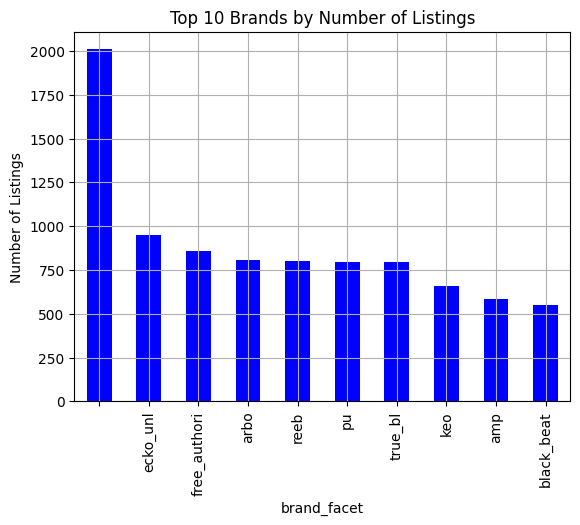

We have found 535 different sellers.
seller_facet
                         1643
retailnet                1411
sandsmarketing            887
bioworldmerchandising     842
arbor                     783
Name: count, dtype: int64 



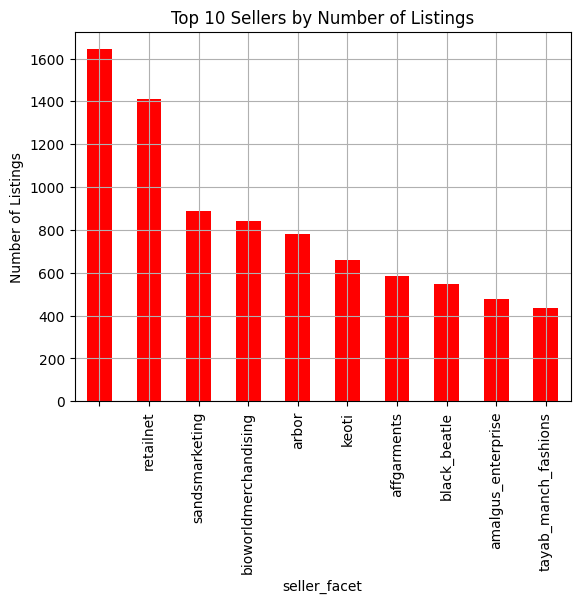

In [16]:
# Look for pid repetitions
print('We have found', df['pid'].nunique(), 'different pids. \n')

# Look for title repetitions
print('We have found', df['title'].nunique(), 'different titles/products.')
title_counts = df['title'].value_counts()
print(title_counts.head(), '\n')

# Look for brand repetitions
print('We have found', df['brand_facet'].nunique(), 'different brands.')
brand_counts = df['brand_facet'].value_counts()
print(brand_counts.head(), '\n')

brand_counts.head(10).plot(kind='bar', color='blue')
plt.title("Top 10 Brands by Number of Listings")
plt.ylabel("Number of Listings")
plt.grid()
plt.show()


# Look for seller repetitions
print('We have found', df['seller_facet'].nunique(), 'different sellers.')
brand_counts = df['seller_facet'].value_counts()
print(brand_counts.head(), '\n')

seller_counts = df['seller_facet'].value_counts()
seller_counts.head(10).plot(kind='bar', color='red')
plt.title("Top 10 Sellers by Number of Listings")
plt.ylabel("Number of Listings")
plt.grid()
plt.show()

## 2.3. Analysis of Numerical Columns

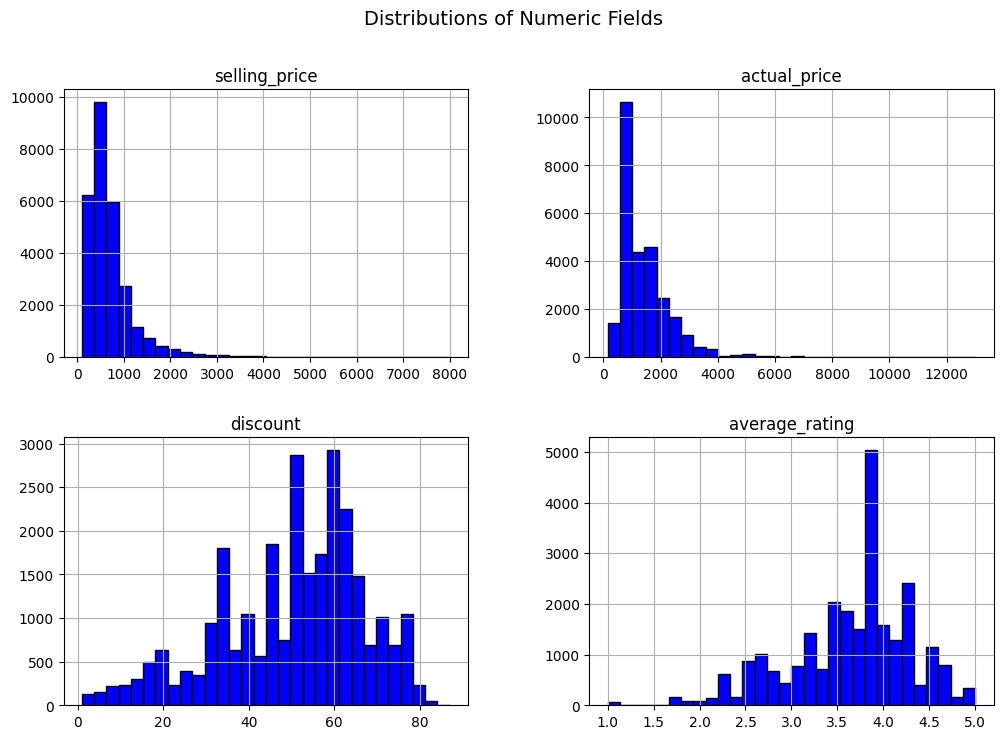

In [ ]:
# Look how data is distributed overall
numeric_cols = ['selling_price', 'actual_price', 'discount', 'average_rating']
df[numeric_cols].hist(bins=30, figsize=(12, 8), color='blue', edgecolor='black')
plt.suptitle("Distributions of Numeric Fields", fontsize=14)
plt.show()

Average discount ratio: 50.47468543622523 %


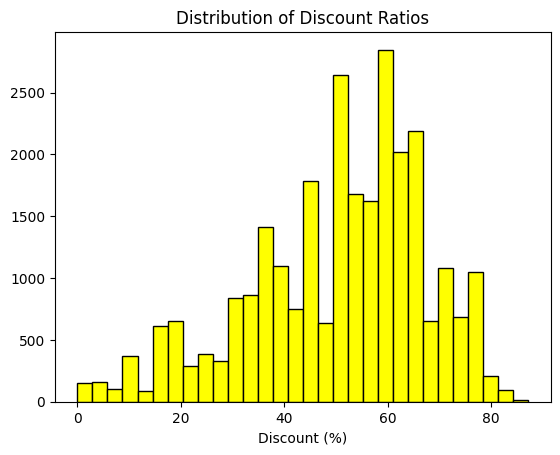

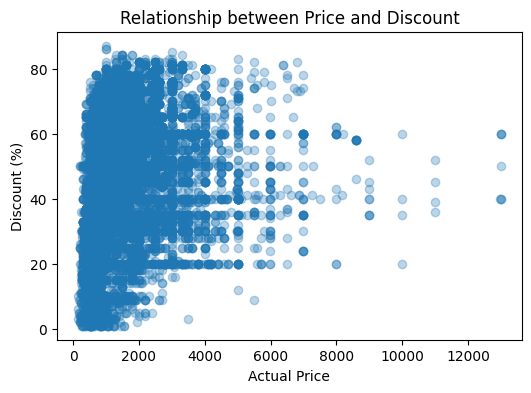

In [18]:
discount_ratio = (df['actual_price'] - df['selling_price']) / df['actual_price']
discount_per = discount_ratio*100
print("Average discount ratio:", discount_ratio.mean()*100, "%")


#let's visualize the discount ratio
plt.hist(discount_per, bins=30, color='yellow', edgecolor='black')
plt.title("Distribution of Discount Ratios")
plt.xlabel("Discount (%)")
plt.show()


plt.figure(figsize=(6,4))
plt.scatter(df['actual_price'], df['discount'], alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Discount (%)")
plt.title("Relationship between Price and Discount")
plt.show()

## 2.5. Text Statistics

The row with most words has 542 words


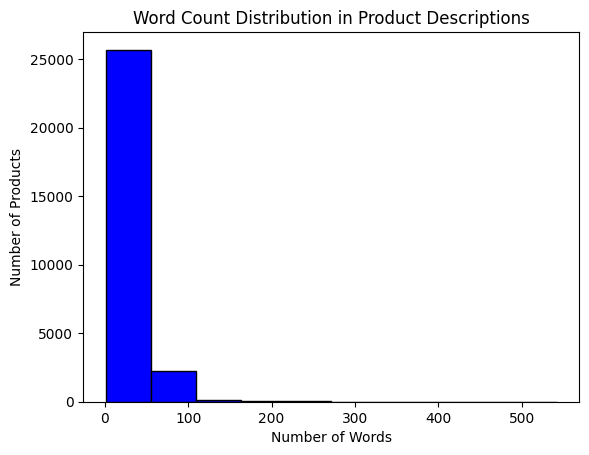

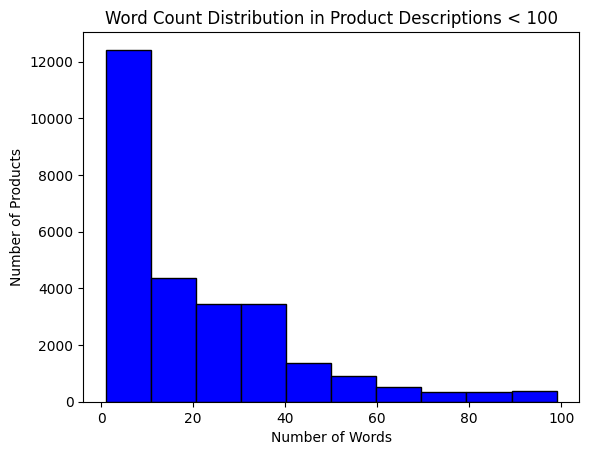

In [19]:
# Word count per product
word_count = df['processed_text'].apply(len)
print('The row with most words has', word_count.max(), 'words')

plt.hist(word_count, bins=10, color='blue', edgecolor='black')
plt.title("Word Count Distribution in Product Descriptions")
plt.xlabel("Number of Words")
plt.ylabel("Number of Products")
plt.show()

plt.hist(word_count[word_count < 100], bins=10, color='blue', edgecolor='black')
plt.title("Word Count Distribution in Product Descriptions < 100")
plt.xlabel("Number of Words")
plt.ylabel("Number of Products")
plt.show()


In [20]:
# Vocabulary size
vocab = set()
for words_list in df['processed_text']:
    for word in words_list:
        vocab.add(word)

print("Vocabulary size:", len(vocab))
print("Average words per product:", word_count.mean())

Vocabulary size: 4633
Average words per product: 23.223931623931623


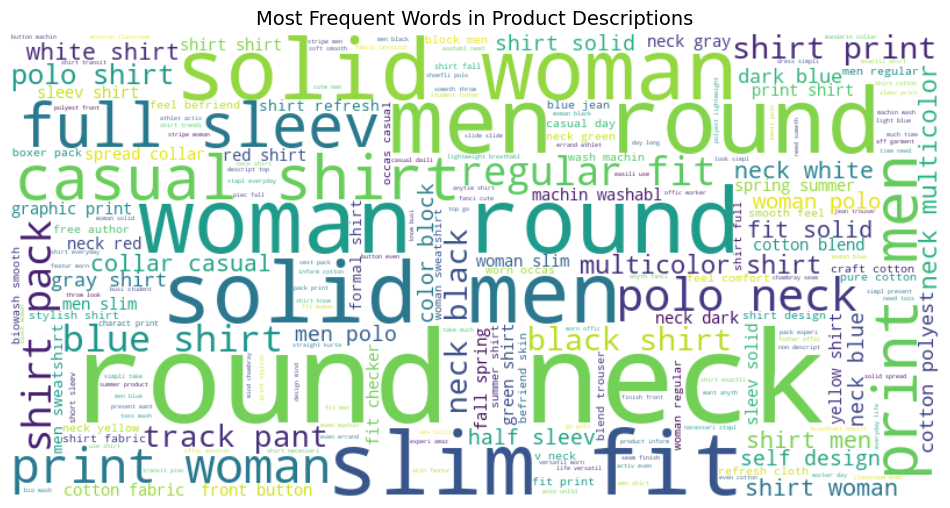

In [21]:
# Most Frequent Words
all_words = ""
for words_list in df['processed_text']:
    # Join that list into a single string separated by spaces
    product_text = " ".join(words_list)

    # Add this string to the global text
    all_words += " " + product_text

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    colormap='viridis'
).generate(all_words)

plt.figure(figsize=(12, 7))        
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')                
plt.title("Most Frequent Words in Product Descriptions", fontsize=14)
plt.show()

EJEMPLOS QUE DA EL PROFE:
- word counting distribution --> DONE
- average sentence length --> NOT DONE y no me parece interesante 
- vocabulary size --> DONE
- ranking of products based on rating, price, discount 
- top sellers and brands --> DONE
- out_of_stock distribution **CAN'T BE DONE WITH THE CURRENT PREPROCESSING**
- word clouds for the most frequent words --> DONE
- entity recognition.